# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstyle data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP.

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


In [3]:
! curl -O https://raw.githubusercontent.com/wz1405/ADS/master/MTA_Fare.npy

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10.2M  100 10.2M    0     0  38.5M      0 --:--:-- --:--:-- --:--:-- 38.6M


In [ ]:
# https://raw.githubusercontent.com/fedhere/PUI2018_fb55/master/HW11_fb55/subway_timeseries_instructions2.ipynb
# https://raw.githubusercontent.com/fedhere/PUI2018_fb55/master/HW11_fb55/MTA_Fare.npy

# Task 1: 
## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
## Identify it and figure out what it is due to.


# Task 2: 
## Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)


# Task 3: 
## Build a classifier that assigns a card type to a time series based on time series features


Populating the interactive namespace from numpy and matplotlib


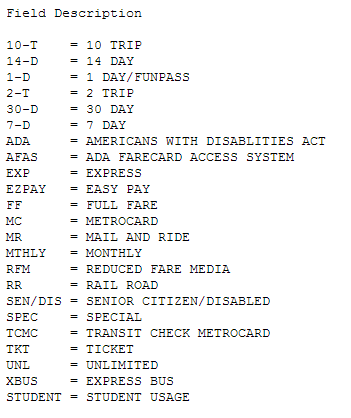

In [898]:
from __future__ import print_function, division
import pylab as pl
import numpy as np
import pandas as pd

from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm
from sklearn import metrics


%pylab inline

from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20
Image(filename = "Ridetypes.png")

This is the information I recieved about the data: "each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/19/2010 to 02/19/2014. "

The data are available to you as a python data cube here:

you can load it as 

np.load(“MTA_Fare.npy") and 


you will end up with a python numpy array of 
shape (600,23,194)

** note that the missing values are inputted as -1**

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans:
np.nanmean
np.nansum...

# HINTS: 

## notes and hints: 

   1) you could coerce the data into a pandas dataframe, but the data is truly a "datacube": a 3D dataset, and flattening it into a pandas dataframe will make it far more difficult to manipulate. I strongly recommand you keep it as a numpy array
    
   2) note that the missing values are inputted as -1. if you want to do things like algebra (summing time series for example) you need to take care of that. If you replace the -1 entries with NaN, you may need to use functions that explicitly know how to deal with NaN: for example, to sum use the np.nansum etc
```
np.nanmean(mtarides)
np.nansum(mtarides)
```
as opposed to just 
```
np.mean(mtarides)
np.sum(mtarides)
```
 
## There are 600 stations, 23 card types. The trick to do this homework succesfully is to "collaps" (by averaging, or summing, depending on the question) the appropriate dimension in different parts of the homework: when you need to work at the station level (if I ask "which station is the one that..."), collaps the card type, when you need to work on the card type, collapse the stations. 

When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average - *np.average(....weight=...)* -. The sum and average functions take an *axis* argument, which allows you to control which axis of the cube gets averaged. The dimension of the resulting object will allow you to check that you averaged over the right axis.


# Possibly useful functions

You are already familiar with and have already used  most of the functions I needed to perform this exercise. Here are some reminders and on few functions and methods that you may not have encountered yet which may be useful. You do not have to use them: there are many ways to do things and you do not have to solve this problem like I did, but here they are in case you need some help:

* the numpy function np.where() returns the index where a condition is true. It is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


*  the array methods 
```
np.array.flatten()
np.array.reshape()
```
     allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which I recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series) you can flatten the array as
     
```
mtaarray.flatten()
```

    which returns the flatten array:

```
mtaRides = np.load("MTA_Fare.npy")

mtaRides.shape
Out[10]: (600, 23, 194)

mtaRides.flatten().shape
Out[11]: (2677200,)
````

# read in data as instructed above

In [674]:
mtaRides = np.load("MTA_Fare.npy")
mtaRides

array([[[56961, 64703, 68002, ..., 36527, 33929, 36824],
        [ 1732,  2083,  2107, ...,  1264,  1172,  1238],
        [  203,   276,   245, ...,   186,   167,   167],
        ..., 
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [   -1,    -1,    -1, ...,  1121,  1377,   712]],

       [[16210, 20179, 21769, ...,    -1,    -1,    -1],
        [  503,   647,   665, ...,    -1,    -1,    -1],
        [   41,    43,    44, ...,    -1,    -1,    -1],
        ..., 
        [    0,     0,     0, ...,    -1,    -1,    -1],
        [    0,     0,     0, ...,    -1,    -1,    -1],
        [   -1,    -1,    -1, ...,    -1,    -1,    -1]],

       [[ 3292,  3429,  3629, ...,  3746,  3406,  3217],
        [  110,    92,   102, ...,   212,   209,   211],
        [    7,     6,    13, ...,    26,    20,    22],
        ..., 
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0, 

In [543]:
print ("MTA array shape:", mtaRides.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mtaRides,axis=1).shape)
print ("MTA array_flattened shape:", mtaRides.flatten().shape)


MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)
MTA array_flattened shape: (2677200,)


# create a "ride types" list based on the metadata I was given

In [544]:
#ridership type list
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


# You need to create a date range to plot properly. 
After that I create a date range (for example with pd.date_range())
in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
all time series, each station each ride type, look like this (pretty ugly)

In [237]:
#"each time series (per station, per ticket type) contains the number of swipes per week for 194 weeks 
# from 05/19/2010 to 02/19/2014

In [238]:
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.date_range.html
Weeks = pd.date_range(start='05/19/2010', end='02/19/2014', freq='W')
Weeks

DatetimeIndex(['2010-05-23', '2010-05-30', '2010-06-06', '2010-06-13',
               '2010-06-20', '2010-06-27', '2010-07-04', '2010-07-11',
               '2010-07-18', '2010-07-25',
               ...
               '2013-12-15', '2013-12-22', '2013-12-29', '2014-01-05',
               '2014-01-12', '2014-01-19', '2014-01-26', '2014-02-02',
               '2014-02-09', '2014-02-16'],
              dtype='datetime64[ns]', length=196, freq='W-SUN')

In [240]:
# deleted 2 weeks at the end
Weeks1 = pd.date_range(start='05/19/2010', end='02/07/2014', freq='W')
Weeks1

DatetimeIndex(['2010-05-23', '2010-05-30', '2010-06-06', '2010-06-13',
               '2010-06-20', '2010-06-27', '2010-07-04', '2010-07-11',
               '2010-07-18', '2010-07-25',
               ...
               '2013-12-01', '2013-12-08', '2013-12-15', '2013-12-22',
               '2013-12-29', '2014-01-05', '2014-01-12', '2014-01-19',
               '2014-01-26', '2014-02-02'],
              dtype='datetime64[ns]', length=194, freq='W-SUN')

In [241]:
# https://www.datacamp.com/community/tutorials/python-numpy-tutorial
# Print out memory address
print(mtaRides.data)

# Print out the shape of `my_array`
print(mtaRides.shape)

# Print out the data type of `my_array`
print(mtaRides.dtype)

# Print out the stride of `my_array`
print(mtaRides.strides)

(600, 23, 194)
int32
(17848, 776, 4)


In [242]:
# Print the number of `my_array`'s dimensions
print(mtaRides.ndim)

# Print the number of `my_array`'s elements
print(mtaRides.size)

# Print information about `my_array`'s memory layout
print(mtaRides.flags)

# Print the length of one array element in bytes
print(mtaRides.itemsize)

# Print the total consumed bytes by `my_array`'s elements
print(mtaRides.nbytes)

# Print the length of `my_array`
print(len(mtaRides))


3
2677200
  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False
4
10708800
600


In [243]:
TotalStations = len(mtaRides)

In [244]:
TotalWeeks = len(mtaRides[1,1])
TotalWeeks

194

In [245]:
TotalTypes = len(mtaRides[2])

In [247]:
mtaRides = mtaRides.astype(float)
mtaRides[mtaRides == -1] = float('NaN')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


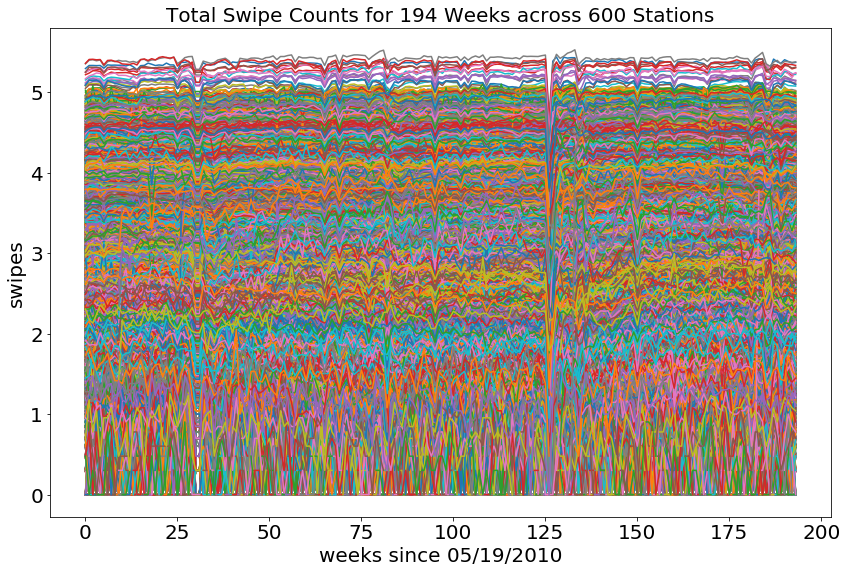

In [522]:
pl.figure(figsize=(14,9))
for i in range(600):
    for j in range(23):
        TotalRides = (mtaRides[i][j])
        pl.plot(np.log10(TotalRides))
pl.xlabel("weeks since 05/19/2010", fontsize=20)
pl.ylabel("swipes", fontsize=20)
pl.title("Total Swipe Counts for 194 Weeks across 600 Stations", fontsize=20)

# Caption:
    This is a plot shows all the ridership amount across the time span for all types of fares for all 600 stations (area of conglomeration of turnstiles).

# 1: event detection 

## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series. Find the date and see what  may have caused this event 



In [383]:
mtaRides = mtaRides.astype('float')
mtaRides[mtaRides==-1] = np.nan

In [384]:
mtaRides_AllNanSumByWeeksArray = np.nansum(mtaRides, axis=0)
print (mtaRides_AllNanSumByWeeksArray)
print (mtaRides_AllNanSumByWeeksArray.shape)
print (mtaRides_AllNanSumByWeeksArray.mean())

[[  1.14946150e+07   1.25268590e+07   1.27666270e+07 ...,   1.31896100e+07
    1.25007560e+07   1.24599470e+07]
 [  5.30524000e+05   5.83533000e+05   5.86194000e+05 ...,   6.95134000e+05
    6.70228000e+05   6.79497000e+05]
 [  4.78010000e+04   5.14860000e+04   5.16360000e+04 ...,   5.87710000e+04
    5.65250000e+04   5.51920000e+04]
 ..., 
 [  6.12800000e+03   6.12000000e+03   6.49000000e+03 ...,   5.39800000e+03
    5.75900000e+03   6.18400000e+03]
 [  3.58000000e+02   4.74000000e+02   4.65000000e+02 ...,   8.62000000e+02
    8.10000000e+02   8.20000000e+02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   1.13272300e+06
    1.37940300e+06   5.35018000e+05]]
(23, 194)
1294841.29874


In [385]:
mtaRides_AllNanSumByWeeksArray1 = np.nansum(mtaRides_AllNanSumByWeeksArray, axis=0)
print (mtaRides_AllNanSumByWeeksArray1)
print (mtaRides_AllNanSumByWeeksArray1.shape)
print (mtaRides_AllNanSumByWeeksArray1.mean())

[ 26720267.  29265971.  29601189.  29387592.  29185768.  26211666.
  28683614.  29125646.  28803814.  28599546.  28312019.  27931015.
  27271701.  28250357.  26687174.  30018756.  30183790.  29052100.
  30068614.  29172431.  30327068.  30190292.  29987273.  30053446.
  30128994.  25164391.  29189219.  30580790.  30106591.  27561217.
  21802973.  21796368.  27483123.  27112540.  26013915.  26433790.
  28660073.  29103923.  29576628.  26721588.  29180204.  29400660.
  29880586.  29677420.  29525360.  30175740.  30196675.  28500091.
  29035465.  30398309.  29992271.  29953470.  27148617.  29850111.
  30165985.  29979266.  30298087.  26744295.  29967687.  29475619.
  29253128.  29429842.  29063294.  27980138.  27924672.  22985008.
  28142943.  31996089.  32506259.  24297825.  32159233.  30747690.
  32641199.  32904387.  31953835.  32131041.  32477470.  27031175.
  31808940.  33123277.  33173847.  31934242.  24565703.  28049643.
  30004428.  28040469.  29387312.  31200600.  31673650.  31126

In [386]:
mtaRides_AllNanSumByWeeksCountTotal = np.nansum(mtaRides_AllNanSum, axis=0)
mtaRides_AllNanSumByWeeksCountTotal

5777581875.0

In [387]:
print ("mean {:.2f}".format(mtaRides_AllNanSumByWeeksArray1.mean()))

mean 29781349.87


In [388]:
print ("Mean Rides: {:.2f}".format(mtaRides_AllNanSumByWeeksArray1.mean()))
print ("StdDev Mean Rides: {:.2f}".format(mtaRides_AllNanSumByWeeksArray1.std()))
threshold = [mtaRides_AllNanSumByWeeksArray1.mean() + 3 * mtaRides_AllNanSumByWeeksArray1.std(), 
              mtaRides_AllNanSumByWeeksArray1.mean() - 3 * mtaRides_AllNanSumByWeeksArray1.std()]
print ("3-sigma threshold {:.2f} {:.2f}".format(*threshold))

Mean Rides: 29781349.87
StdDev Mean Rides: 2983960.42
3-sigma threshold 38733231.14 20829468.61


In [389]:
mtaRides[(mtaRides_AllNanSumByWeeksArray1[0] > thresholds[0])]

array([], shape=(0, 600, 23, 194), dtype=float64)

In [390]:
# the lowest counts happened at 126 weeks from 05/19/2010
np.nanargmin(mtaRides_AllNanSumByWeeksArray1)

126

# That's roughly 2 and half years from 05/19/2010, which is around 10/14/2012. We assume it is due to the Hurrican Sandy when the subway system was submerged...

In [523]:
Weeks[125]

Timestamp('2012-10-14 00:00:00', freq='W-SUN')

In [395]:
np.nanmin(mtaRides_AllNanSumByWeeksArray1)

5218686.0

In [396]:
np.nanmax(mtaRides_AllNanSumByWeeksArray1)

34071477.0

In [397]:
Weeks1.shape

(194,)

In [398]:
mtaRides_AllNanSumByWeeksArray1.shape

(194,)

In [399]:
mtaRides.shape

(600, 23, 194)

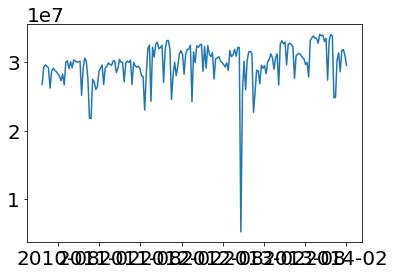

In [400]:
pl.plot(Weeks1,mtaRides_AllNanSumByWeeksArray1)

# Caption:
    This plot can better visualize the trend of turnstile data. 

 # 2: finding trends

## NOTE ON THE TREND DETECTION:
### you should find the *ride type* that has the steepest increase, and the steepest decrease. Notice: we are looking for something that has a more or less constant trend

### to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type. 

### you can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the *number of rides* near the beginning to the *number of rides* near the end of the time series.

### notice that you should inspect the time series, algorithmically or at least by eye, to ensure you see a trend, and not just changing structure. Below is an example of a lightcurve with structure (top) and a lightcurve with a constant trend (bottom) both showing a large deviation between the beginning and the end of the time series


In [401]:
mtaRides_AllNanSumByWeeksArray1.shape

(194,)

In [402]:
mtaRides_AllNanSumByWeeksArray.shape

(23, 194)

In [431]:
# Initially I used reshape function but things turn out to be wrong. Took me a while to use Transpose instead.
mtaRides_AllNanSumByWeeksArray_Reshape = mtaRides_AllNanSumByWeeksArray.T

In [432]:
mtaRides_AllNanSumByWeeksDF = pd.DataFrame(data=mtaRides_AllNanSumByWeeksArray_Reshape, dtype=np.float)

In [555]:
mtaRides_AllNanSumByWeeksDF.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,11494615.0,530524.0,47801.0,186551.0,46808.0,3697443.0,8551937.0,10063.0,333197.0,512032.0,...,123134.0,790110.0,59809.0,28221.0,0.0,124693.0,21060.0,6128.0,358.0,0.0
1,12526859.0,583533.0,51486.0,199229.0,64353.0,3981808.0,9486394.0,11847.0,282755.0,578023.0,...,151948.0,908068.0,69209.0,32333.0,0.0,121713.0,21670.0,6120.0,474.0,0.0
2,12766627.0,586194.0,51636.0,199668.0,56994.0,4033030.0,9476538.0,12277.0,302028.0,615537.0,...,151538.0,914124.0,69574.0,32618.0,0.0,122181.0,21433.0,6490.0,465.0,0.0
3,12653675.0,562602.0,52063.0,196389.0,37429.0,4032753.0,9450081.0,11221.0,305513.0,606270.0,...,147094.0,902549.0,68099.0,32404.0,0.0,122051.0,21630.0,6590.0,484.0,0.0
4,12809694.0,548858.0,51153.0,194883.0,35210.0,3925446.0,9294002.0,10515.0,335780.0,563446.0,...,137888.0,855573.0,66377.0,31933.0,176.0,119776.0,20297.0,6313.0,452.0,0.0


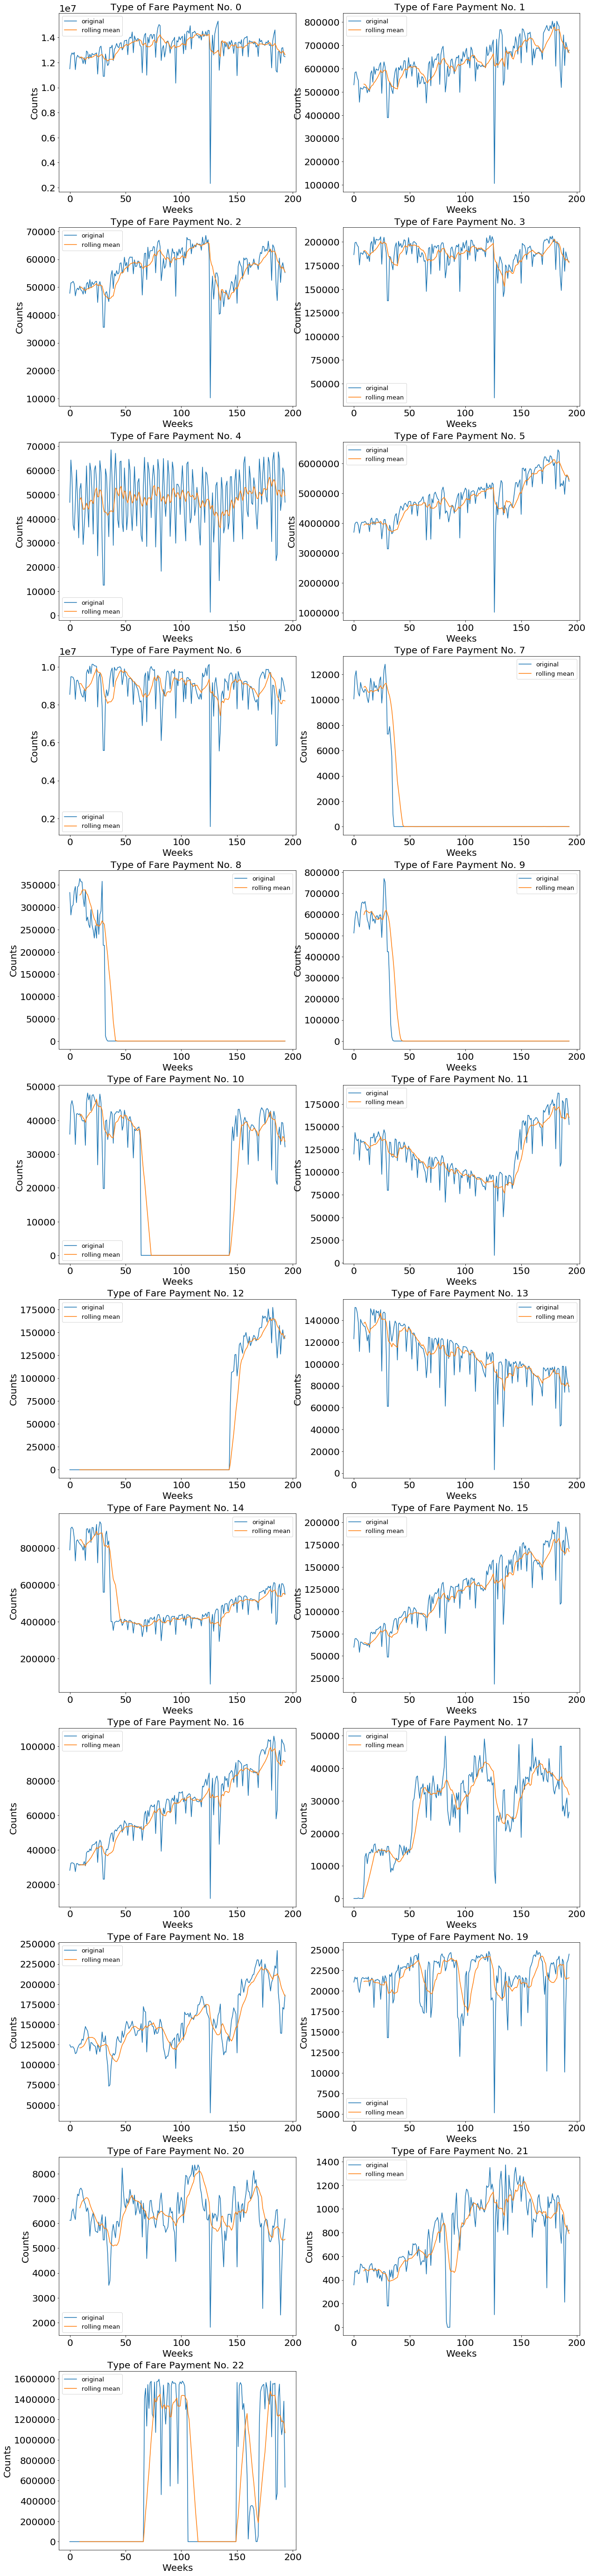

In [436]:
# can choose whether to view the original plot or just the rolling mean or both.
fig = pl.figure(figsize=(20,100))

for i in mtaRides_AllNanSumByWeeksDF.keys():

    ax = fig.add_subplot(12,2,i+1)

    mtaRides_AllNanSumByWeeksDF_rmean = mtaRides_AllNanSumByWeeksDF[i].rolling(10).mean()
    ax.plot(np.arange(len(mtaRides_AllNanSumByWeeksDF[i])), mtaRides_AllNanSumByWeeksDF[i], label="original")
    ax.plot(np.arange(len(mtaRides_AllNanSumByWeeksDF[i])), mtaRides_AllNanSumByWeeksDF_rmean, label="rolling mean")
    ax.set_title("Type of Fare Payment No. {} ".format(i), fontsize=20)
    pl.ylabel("Counts")
    pl.xlabel("Weeks")
    pl.legend(fontsize=13)
    

# Captions:
    These are graphs of trip amount over time for each fare type and the rolling mean repectively which shows the derivative(slope) of the change of the trip amount. 

In [439]:
# for j in mtaRides_AllNanSumByWeeksDF.keys():
#     print (mtaRides_AllNanSumByWeeksDF[j].describe())

In [533]:
# calculate the change by subtract the last ten weeks average by first ten weeks average.
# ignoring those invalid graphs (having constant zeros for a long period of time) including fare payment type:7,8,9,10,12,22 
for l in mtaRides_AllNanSumByWeeksDF.keys():
    print ("Change of Fare Payment No. {} ".format(l), (mtaRides_AllNanSumByWeeksDF[l][183:193]).mean() - (mtaRides_AllNanSumByWeeksDF[l][0]).mean())
    print ("Std Change".format(l), mtaRides_AllNanSumByWeeksDF[l].std())

Change of Fare Payment No. 0  1300356.1
Std Change 1215646.4610982689
Change of Fare Payment No. 1  148389.9
Std Change 90866.08752005553
Change of Fare Payment No. 2  8576.4
Std Change 7618.889095486929
Change of Fare Payment No. 3  -6690.5
Std Change 17636.10428858537
Change of Fare Payment No. 4  4831.6
Std Change 12666.524996190325
Change of Fare Payment No. 5  1875911.8
Std Change 765024.1202661686
Change of Fare Payment No. 6  -318603.8
Std Change 1056175.2113032066
Change of Fare Payment No. 7  -10060.6
Std Change 4072.469848465143
Change of Fare Payment No. 8  -333193.4
Std Change 111160.77497653922
Change of Fare Payment No. 9  -512031.0
Std Change 221877.0087588072
Change of Fare Payment No. 10  -1063.3
Std Change 19681.304649791633
Change of Fare Payment No. 11  43650.2
Std Change 29733.58728208236
Change of Fare Payment No. 12  145475.8
Std Change 63305.69816063872
Change of Fare Payment No. 13  -41486.7
Std Change 23803.335905342286
Change of Fare Payment No. 14  -235684.2

# In observation of plots and the loop result above, fare type 5 experiences the largest increase, and fare type 6 experiences the largest drop.

In [440]:
# Try the average of the data frame below:

In [441]:
mtaRides_AllNanSumByWeeksArray.shape

(23, 194)

In [442]:
mtaRides_AllNanSumByWeeksArrayAVE = np.nanmean(mtaRides, axis=0)
print (mtaRides_AllNanSumByWeeksArrayAVE)
print (mtaRides_AllNanSumByWeeksArrayAVE.shape)
print (mtaRides_AllNanSumByWeeksArrayAVE.mean())

[[  2.48801190e+04   2.71732299e+04   2.75737084e+04 ...,   2.85489394e+04
    2.69994730e+04   2.69695823e+04]
 [  1.14832035e+03   1.26579826e+03   1.26607775e+03 ...,   1.50461905e+03
    1.44757667e+03   1.47077273e+03]
 [  1.03465368e+02   1.11683297e+02   1.11524838e+02 ...,   1.27209957e+02
    1.22084233e+02   1.19463203e+02]
 ..., 
 [  1.32640693e+01   1.32754881e+01   1.40172786e+01 ...,   1.16839827e+01
    1.24384449e+01   1.33852814e+01]
 [  7.74891775e-01   1.02819957e+00   1.00431965e+00 ...,   1.86580087e+00
    1.74946004e+00   1.77489177e+00]
 [             nan              nan              nan ...,   2.45178139e+03
    2.97927214e+03   1.15804762e+03]]
(23, 194)
nan


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


In [443]:
mtaRides_AllNanSumByWeeksArrayAVE_Reshape = mtaRides_AllNanSumByWeeksArrayAVE.T
mtaRides_AllNanSumByWeeksAVEDF = pd.DataFrame(data=mtaRides_AllNanSumByWeeksArrayAVE_Reshape, dtype=np.float)

In [444]:
mtaRides_AllNanSumByWeeksAVEDF.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,24880.119048,1148.320346,103.465368,403.790043,101.316017,8003.123377,18510.686147,21.781385,721.205628,1108.294372,...,266.523810,1710.194805,129.456710,61.084416,0.00000,269.898268,45.584416,13.264069,0.774892,NaN
1,27173.229935,1265.798265,111.683297,432.167028,139.594360,8637.327549,20577.861171,25.698482,613.351410,1253.845987,...,329.605206,1969.778742,150.127983,70.136659,0.00000,264.019523,47.006508,13.275488,1.028200,NaN
2,27573.708423,1266.077754,111.524838,431.248380,123.097192,8710.647948,20467.684665,26.516199,652.328294,1329.453564,...,327.295896,1974.349892,150.267819,70.449244,0.00000,263.889849,46.291577,14.017279,1.004320,NaN
3,27329.751620,1215.123110,112.447084,424.166307,80.840173,8710.049676,20410.542117,24.235421,659.855292,1309.438445,...,317.697624,1949.349892,147.082073,69.987041,0.00000,263.609071,46.717063,14.233261,1.045356,NaN
4,27607.099138,1182.883621,110.243534,420.006466,75.883621,8460.012931,20030.176724,22.661638,723.663793,1214.323276,...,297.172414,1843.907328,143.053879,68.821121,0.37931,258.137931,43.743534,13.605603,0.974138,NaN


In [534]:
# A plot of the result of all the averages. Hiding it from showing. 
# fig = pl.figure(figsize=(20,100))
# slope1 = []
# for i in mtaRides_AllNanSumByWeeksAVEDF.keys():

#     ax = fig.add_subplot(12,2,i+1)

#     mtaRides_AllNanSumByWeeksAVEDF_rmean = mtaRides_AllNanSumByWeeksAVEDF[i].rolling(10).mean()
#     ax.plot(np.arange(len(mtaRides_AllNanSumByWeeksAVEDF[i])), mtaRides_AllNanSumByWeeksAVEDF[i], label="original")
#     ax.plot(np.arange(len(mtaRides_AllNanSumByWeeksAVEDF[i])), mtaRides_AllNanSumByWeeksAVEDF_rmean, label="rolling mean")
    
#     slope1.append(mtaRides_AllNanSumByWeeksAVEDF[i].rolling(10).mean().dropna().head(10).sum() / mtaRides_AllNanSumByWeeksAVEDF[i].rolling(10).mean().dropna().tail(10).sum())
#     ax.set_title("Type of Fare Payment No. {} Slope: {}".format(i,slope[i]), fontsize=20)
#     pl.ylabel("Counts")
#     pl.xlabel("Weeks")
#     pl.legend(fontsize=13)

# 3. Build  models that classified the *ride type* based on the time series characteristics using random forests. 

1. Clean the data from missing values (drop time series with NaNs)

2. Use all the time series, and use the ticket type as a label (remember that the original data is sorted by ticket type in axis=1).

3. Calculate the mean, standard deviation for each time series and by station and create the features as instructed below

4. Split the training and test data (66%/33%)

5. Build and test a random forest model that predicts the ticket type based on 4 engineered features (see below).

6. Build and test a random forest model that predicts the ticket type based on all datapoint in the time series (194 features)

7. Plot a confusion matrix for each model (discuss)

8. Compare the models using sklearn.metrics classification_report

9. Find the 2 most important features in each model 



## Build one that uses as input features the following engineered features :
- the time series mean divided by the mean of all time series for that station
- the time series standard deviation by the  standard deviation of all time series for that station
- the slope and intercept of a line fit to the standardized time series 
        (time_series - time_series.mean())/time_series.std()
        

In [779]:
# 3.1 -> Question 3 Part 1
# Some code structure referred to previous year's instruction code.
mtaRides = np.load("MTA_Fare.npy")
mtaRides

array([[[56961, 64703, 68002, ..., 36527, 33929, 36824],
        [ 1732,  2083,  2107, ...,  1264,  1172,  1238],
        [  203,   276,   245, ...,   186,   167,   167],
        ..., 
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [   -1,    -1,    -1, ...,  1121,  1377,   712]],

       [[16210, 20179, 21769, ...,    -1,    -1,    -1],
        [  503,   647,   665, ...,    -1,    -1,    -1],
        [   41,    43,    44, ...,    -1,    -1,    -1],
        ..., 
        [    0,     0,     0, ...,    -1,    -1,    -1],
        [    0,     0,     0, ...,    -1,    -1,    -1],
        [   -1,    -1,    -1, ...,    -1,    -1,    -1]],

       [[ 3292,  3429,  3629, ...,  3746,  3406,  3217],
        [  110,    92,   102, ...,   212,   209,   211],
        [    7,     6,    13, ...,    26,    20,    22],
        ..., 
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0, 

In [710]:
mtaRides = mtaRides.astype(float)
mtaRides[mtaRides == -1] = float('NaN')

In [714]:
Arr31 =  mtaRides.transpose(2,0,1).reshape(mtaRides.shape[2], mtaRides.shape[1]*mtaRides.shape[0]).T
Arr311 = Arr31[Arr31.std(1)>0]
Arr311.shape

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


(7660, 194)

In [715]:
Df311 = pd.DataFrame(data=Arr311, dtype=np.float)
Df311.shape

(7660, 194)

In [719]:
Df312 = Df311.dropna()
Df312.head()

,0,1,2,3,4,5,6,7,8,9,...,184,185,186,187,188,189,190,191,192,193
0,3292.0,3429.0,3629.0,2808.0,3614.0,2601.0,2848.0,2798.0,2888.0,3591.0,...,3506.0,2894.0,2679.0,3337.0,3599.0,3273.0,3418.0,3746.0,3406.0,3217.0
1,110.0,92.0,102.0,79.0,93.0,74.0,72.0,92.0,97.0,95.0,...,192.0,167.0,160.0,180.0,204.0,166.0,191.0,212.0,209.0,211.0
2,7.0,6.0,13.0,7.0,5.0,7.0,7.0,6.0,3.0,4.0,...,21.0,17.0,18.0,20.0,19.0,13.0,19.0,26.0,20.0,22.0
3,41.0,51.0,47.0,37.0,50.0,43.0,44.0,32.0,43.0,57.0,...,25.0,18.0,24.0,20.0,25.0,29.0,31.0,28.0,24.0,22.0
4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,...,2.0,1.0,1.0,10.0,8.0,6.0,5.0,5.0,6.0,0.0


# 3.2  Use all the time series, and use the ticket type as a label (remember that the original data is sorted by ticket type in axis=1).
& 3.3 Calculate the mean, standard deviation for each time series and by station and create the features as instructed below

In [722]:
# 3.2 & # 3.3

In [742]:
# Df321 -> mean for each row(station)
Df321 = Df312

In [743]:
# Ref: https://stackoverflow.com/questions/33750326/compute-row-average-in-pandas
Df321['Mean'] = Df321.mean(axis=1)

In [744]:
Df321.head()

,0,1,2,3,4,5,6,7,8,9,...,186,187,188,189,190,191,192,193,Mean,StandardDeviation
0,3292.0,3429.0,3629.0,2808.0,3614.0,2601.0,2848.0,2798.0,2888.0,3591.0,...,2679.0,3337.0,3599.0,3273.0,3418.0,3746.0,3406.0,3217.0,3532.810252,391.400426
1,110.0,92.0,102.0,79.0,93.0,74.0,72.0,92.0,97.0,95.0,...,160.0,180.0,204.0,166.0,191.0,212.0,209.0,211.0,144.164065,43.619698
2,7.0,6.0,13.0,7.0,5.0,7.0,7.0,6.0,3.0,4.0,...,18.0,20.0,19.0,13.0,19.0,26.0,20.0,22.0,17.983584,8.245400
3,41.0,51.0,47.0,37.0,50.0,43.0,44.0,32.0,43.0,57.0,...,24.0,20.0,25.0,29.0,31.0,28.0,24.0,22.0,30.248432,9.899215
4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,...,1.0,10.0,8.0,6.0,5.0,5.0,6.0,0.0,3.000074,4.441455


In [745]:
# Df321 -> std for each row(station)
Df321['StandardDeviation'] = Df321.std(axis=1)
Df321.head()

,0,1,2,3,4,5,6,7,8,9,...,186,187,188,189,190,191,192,193,Mean,StandardDeviation
0,3292.0,3429.0,3629.0,2808.0,3614.0,2601.0,2848.0,2798.0,2888.0,3591.0,...,2679.0,3337.0,3599.0,3273.0,3418.0,3746.0,3406.0,3217.0,3532.810252,450.859459
1,110.0,92.0,102.0,79.0,93.0,74.0,72.0,92.0,97.0,95.0,...,160.0,180.0,204.0,166.0,191.0,212.0,209.0,211.0,144.164065,44.082746
2,7.0,6.0,13.0,7.0,5.0,7.0,7.0,6.0,3.0,4.0,...,18.0,20.0,19.0,13.0,19.0,26.0,20.0,22.0,17.983584,8.145703
3,41.0,51.0,47.0,37.0,50.0,43.0,44.0,32.0,43.0,57.0,...,24.0,20.0,25.0,29.0,31.0,28.0,24.0,22.0,30.248432,9.892102
4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,...,1.0,10.0,8.0,6.0,5.0,5.0,6.0,0.0,3.000074,4.225879


In [746]:
Df321.shape

(7660, 196)

In [747]:
stationsmeans = Df321['Mean'].values
stationsmeans.shape

(7660,)

In [6]:
stationsmeans = ...
stationsmeans.shape

(600,)

In [7]:
stationsstd = ...
stationsstd.shape

(600,)

In [788]:
stationid = np.concatenate([np.array([i] * 23) for i in range(600)])
stationid[mtaRides.reshape(600*23, 194).std(1) > 0]

array([  0,   0,   0, ..., 550, 550, 550])

In [787]:
mtaRides = np.load("MTA_Fare.npy")


In [789]:
# mtaRides = mtaRides.astype('float')
# mtaRides[mtaRides==-1] = np.nan

In [797]:
tots = mtaRides.transpose(2,0,1).reshape(mtaRides.shape[2], mtaRides.shape[1]*mtaRides.shape[0]).T
tots1 = tots[tots.std(1)>0]
tots1.shape

(9317, 194)

In [798]:
tots1

array([[56961, 64703, 68002, ..., 36527, 33929, 36824],
       [ 1732,  2083,  2107, ...,  1264,  1172,  1238],
       [  203,   276,   245, ...,   186,   167,   167],
       ..., 
       [    0,     0,     0, ...,  1959,  1773,  1667],
       [  202,   150,   135, ...,   213,   168,   214],
       [   -1,    -1,    -1, ...,     0,     0,     0]], dtype=int32)

In [763]:
# tots = tots[~numpy.isnan(tots)]

In [813]:
# sales['price'] = (sales['price'] - sales['price'].mean()) / sales['price'].std()


In [901]:
Df321['normed_time_series_mean'] = (Df321['Mean'] - Df321['Mean'].mean()) / Df321['Mean'].std()
Df321['normed_time_series_std'] = (Df321['StandardDeviation'] - Df321['StandardDeviation'].mean()) / Df321['StandardDeviation'].std() 
Df321['Sum'] = (Df321).sum() - Df321['normed_time_series_std'] - Df321['normed_time_series_mean']

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/pandas/core/indexes/base.py:3772: RuntimeWarning: unorderable types: str() < int(), sort order is undefined for incomparable objects
  return this.join(other, how=how, return_indexers=return_indexers)


In [902]:
Df321.head()

,0,1,2,3,4,5,6,7,8,9,...,189,190,191,192,193,Mean,StandardDeviation,normed_time_series_mean,normed_time_series_std,Sum
0,3292.0,3429.0,3629.0,2808.0,3614.0,2601.0,2848.0,2798.0,2888.0,3591.0,...,3273.0,3418.0,3746.0,3406.0,3217.0,3532.810252,450.859459,-0.007857,-0.098307,2.543509e+07
1,110.0,92.0,102.0,79.0,93.0,74.0,72.0,92.0,97.0,95.0,...,166.0,191.0,212.0,209.0,211.0,144.164065,44.082746,-0.267502,-0.313464,2.783817e+07
2,7.0,6.0,13.0,7.0,5.0,7.0,7.0,6.0,3.0,4.0,...,13.0,19.0,26.0,20.0,22.0,17.983584,8.145703,-0.277170,-0.332473,2.815514e+07
3,41.0,51.0,47.0,37.0,50.0,43.0,44.0,32.0,43.0,57.0,...,29.0,31.0,28.0,24.0,22.0,30.248432,9.892102,-0.276231,-0.331549,2.792106e+07
4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,...,6.0,5.0,5.0,6.0,0.0,3.000074,4.225879,-0.278319,-0.334546,2.772745e+07


In [1059]:
Df322 = Df321.iloc[:,:-5]
Df323 = Df321.iloc[:,:-5]

In [802]:
tsmean = np.nanmean(tots1, axis=1)
tsmean.shape

(9317,)

In [803]:
tsmean[:10]

array([  5.79828866e+04,   1.80932474e+03,   2.34865979e+02,
         7.30041237e+02,   2.90108247e+02,   1.98267680e+04,
         3.02422629e+04,   8.47422680e+00,   9.67087629e+02,
         4.26824742e+02])

In [805]:
tsstdev = np.nanstd(tots1, axis=1)
tsstdev[:10]

array([ 18634.01356896,    540.86282986,     70.42970157,    200.63432488,
          143.21224115,   6240.83828981,  10440.45335489,     18.66337324,
         2305.01269034,    987.653128  ])

In [823]:
tots2 = np.nansum(tots1,axis=1)

In [824]:
tots2.shape

(9317,)

In [835]:
standardizedts.shape

(9317,)

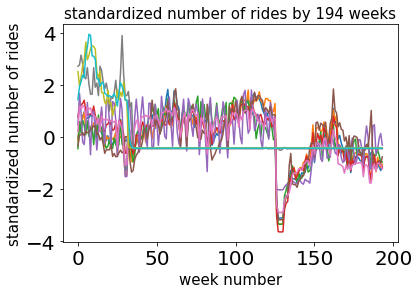

In [904]:
# Guanjia Wang taught me his part of code for this particular graph shown below

standardizedts = []
for i in range(7660):
    standardizedts.append((tots[i]-tsmean[i])/tsstdev[i])
standardizedts = np.array(standardizedts)
for j in range(10):
    pl.plot(standardizedts[j])
pl.xlabel("week number", fontsize = 15)
pl.ylabel("standardized number of rides", fontsize=15)
pl.title("standardized number of rides by 194 weeks", fontsize = 15)
pl.show()

# Caption: 
    This is a plot of standardized number of rides by 194 weeks by 23 types of fares.

In [892]:
standardizedtsDF = pd.DataFrame(standardizedts)
print (standardizedtsDF.shape)
standardizedtsDF.head()
# print (standardizedtsDF.tail())

(7660, 194)


,0,1,2,3,4,5,6,7,8,9,...,184,185,186,187,188,189,190,191,192,193
0,-0.054840,0.360637,0.537679,0.785934,0.959703,0.775470,0.708549,0.725293,0.848884,0.779978,...,-0.771433,-0.708859,-0.591815,-1.016039,-1.105446,-1.294347,-1.053176,-1.151437,-1.290859,-1.135498
1,-0.142966,0.505998,0.550371,0.700132,0.933093,0.206476,0.485660,0.350690,0.409855,0.315561,...,-0.710577,-1.339202,-1.561070,-0.971272,-0.743857,-1.339202,-0.777137,-1.008250,-1.178348,-1.056321
2,-0.452451,0.584044,0.143888,0.640838,0.427860,0.087094,0.612441,0.016101,0.328470,0.413661,...,-0.253671,-0.651231,-1.204974,-0.580238,-0.736422,-0.708025,-0.495047,-0.693826,-0.963599,-0.963599
3,0.762376,1.136190,1.225906,1.280732,1.405337,0.981680,0.837139,0.857075,0.881996,0.881996,...,-0.767771,-1.345937,-1.704799,-1.061838,-0.683040,-1.156538,-0.957170,-0.922281,-1.066823,-1.201396
4,0.474064,1.668096,0.920953,-0.203253,-0.294027,0.501994,1.318964,0.383290,-0.685055,0.865092,...,-0.000756,-1.264614,-1.159875,0.411220,0.467081,-0.650142,-0.489541,-0.063600,0.131914,-0.314975


In [847]:
# 3.4 Train Test Split

In [854]:
label = (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,0,1,2)

In [921]:
# label1 = len(np.nansum(mtaRides,axis=0))
# label1

In [907]:
for i in range(len(label)):
    allfits = [sm.OLS([label[i]], [standardizedtsDF[i]]).fit() ]

In [ ]:
# allfits = sm.OLS(label, mtaRides).fit()
# [a.params[0] for a in allfits[:10]]

In [916]:
normedtsmean = Df321['normed_time_series_mean'].values
normedtsstd = Df321['normed_time_series_std'].values
# df = df.values
normedtsstd.shape

(7660,)

In [927]:
tots2 = tots1[~np.isnan(tots1).any(axis=1)]
tots2.shape

(9317, 194)

In [1066]:
X_train, X_test, y_train, y_test = train_test_split(
    Df322, Df323, test_size=0.33, random_state=42, shuffle=True)

In [1067]:
np.array(X_train).shape, np.array(X_test).shape, np.array(y_train).shape, np.array(y_test).shape

((5132, 194), (2528, 194), (5132, 194), (2528, 194))

In [1068]:
# (~np.isfinite(X_train)).sum(),(~np.isfinite(X_test)).sum(),(~np.isfinite(y_train)).sum(),(~np.isfinite(y_test )).sum()

In [1069]:
# clf =  ensemble.RandomForestClassifier().fit(titanic_short.values, titanic["Survived"])
# clf.score(titanic_short.values, titanic["Survived"])

In [1070]:
(~np.isfinite(X_train)).sum(),(~np.isfinite(X_test)).sum(),(~np.isfinite(y_train)).sum(),(~np.isfinite(y_test )).sum()

(0      0
 1      0
 2      0
 3      0
 4      0
 5      0
 6      0
 7      0
 8      0
 9      0
 10     0
 11     0
 12     0
 13     0
 14     0
 15     0
 16     0
 17     0
 18     0
 19     0
 20     0
 21     0
 22     0
 23     0
 24     0
 25     0
 26     0
 27     0
 28     0
 29     0
       ..
 164    0
 165    0
 166    0
 167    0
 168    0
 169    0
 170    0
 171    0
 172    0
 173    0
 174    0
 175    0
 176    0
 177    0
 178    0
 179    0
 180    0
 181    0
 182    0
 183    0
 184    0
 185    0
 186    0
 187    0
 188    0
 189    0
 190    0
 191    0
 192    0
 193    0
 Length: 194, dtype: int64, 0      0
 1      0
 2      0
 3      0
 4      0
 5      0
 6      0
 7      0
 8      0
 9      0
 10     0
 11     0
 12     0
 13     0
 14     0
 15     0
 16     0
 17     0
 18     0
 19     0
 20     0
 21     0
 22     0
 23     0
 24     0
 25     0
 26     0
 27     0
 28     0
 29     0
       ..
 164    0
 165    0
 166    0
 167    0
 168    0
 16

In [ ]:
clf = rfc().fit(X_train,y_train)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [ ]:
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [1]:
metrics.confusion_matrix(y_test, y_pred)

In [2]:
imshow(confusion_matrix(y_test, y_pred))

 and use classification_report to assess the model and clf.feature_importances_ to find the important features

## Build a model that uses as input features each time stamp (194 features) :


In [87]:
# use the same split ratio
X_train, X_test, y_train, y_test = train_test_split(
    ...

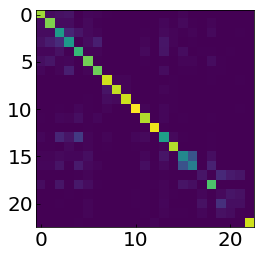

In [90]:
imshow(confusion_matrix(y_test, y_pred))

In [91]:
print(classification_report(y_test, y_pred, target_names=ridetype))

             precision    recall  f1-score   support

        10t       0.75      0.82      0.78       160
        14d       0.75      0.79      0.77       157
         1d       0.50      0.60      0.55       141
         2t       0.55      0.54      0.55       154
        30d       0.59      0.73      0.65       142
         7d       0.71      0.79      0.74       154
        ada       0.82      0.81      0.81       149
       afas       0.88      0.95      0.92       150
        exp       0.96      0.92      0.94       153
         ez       0.97      0.92      0.95       154
         ff       0.96      0.92      0.94       168
         mc       0.82      0.87      0.84       157
         mr       0.97      0.99      0.98       152
      month       0.57      0.55      0.56       159
        rfm       0.88      0.90      0.89       151
         rr       0.53      0.48      0.50       151
        sen       0.55      0.40      0.46       162
       spec       0.39      0.17      0.24   